### Report on “Breaking the Softmax Bottleneck: A High-Rank RNN Language Model” experiments

 **_Marcin Gruza, University of Wroclaw_**


I am student at the University of Wroclaw and this is a report on a project that I made for Neural Networks and Deep Learning class. My main goal in this project was to test the method and possibly reproduce authors’ results of experiments. I hope the report will be helpful for people who are thinking about using this method in their network.
The paper introduces novel type of softmax layer which can be used in recurrent neural networks. It is called Mixture of Softmaxes. The idea is based on extending limited rank of probability matrix produced by standard softmax. The method is easy to understand and implement since we only have to modify the softmax layer of our net. Also, the paper is very easy to follow, and I had no problems with understanding it even though I am novice in neural nets.

## Experiments and results
In experiments I used official authors’ implementation with my modifications. I compared Mixture of Softmaxes, Mixture of Contexts and models with standard softmax layer with different embedding sizes(400, 500, 600) and learning rates(20,30). Due to lack of time and resources I made my experiments mainly on Penn Treebank dataset and I limited training time to 100 epochs for most tests. I’ve run all experiments with few random seeds to ensure that the initialization of weights won’t affect results. 

The table and plots summarizes my results. AWD-LSTM is model with standard softmax from [Merity 2017]. 



[![PTB](images/ptbresults.png)](ResultsPTB.html "Click to open in new card")
[![WT2](images/wt2results.png)](ResultsWT2.html "Click to open in new card")

# Penn Treebank 
![PTB plot](images/ptbplot.png)

# WT2 
![WT2 plot](images/wt2plot.png)


Increasing embedding size in standard softmax gives some improvement on Penn Treebank dataset, however it fails on Wikitext-2 as its vocabulary set is too big. The MoC model also improves the perplexity, but it’s worse than MoS. Both the training and validation errors on MoS are smaller than in simple softmax. It proves that the method isn’t hiding any regularization effect, but gives better expressiveness.  

After 100 epochs, the best result for standard softmax, MoC and MoS models were 62.99, 62.03 and 60.68 respectively. Continuation of training of models with the best perplexity at 100th epoch up to 150/200 epoch shows that MoS has more potential than standard softmax. All of the experiments show that the Mixture of Softmaxes gives better perplexity than other models. 

## Theoretical Experiments

### KLD
Kullback–Leibler divergence is a way to compare two probabilty distributions. Authors used it to check how different are probability distributions for some contexts sampled from test data. I fixed sampled contexts for all experiments. My results are similar to those from the paper.

|Model|KLD|
|-------|--------|
|Softmax(500embedded)|4.226|
|MoC(15 experts)|5.063|
|MoS(15 experts)|5.273|

### SVD

Authors use SVD on a matrix of probabilites for a context sequence. Let $B$ be $NxD$ matrix and C be $dxM$ matrix. Authors claim that rank of probability matrix $A = BC$ is limited by $d$(embedding size). However the matrix of ppbs is a result of matrix multiplication followed by non-linear function ($A = Log(Sotftmax(BC))$) so its rank can be greater than $d$.

My experiment shows that standard softmax model probability matrix rank is greater than embedding size, but it's much smaller than in MoC and MoS models. 

To validate the method of estimating rank I checked number of singular values in a standard softmax model right after decoding layer, before taking softmax, so it is simply $A = BC$. Then, theoretically, rank of such matrix should be equal to the embedding size of the model. Model with embedding size 500 had 501 singular values so it is quite accurate.

|Model|Rank of probability matrix A|
|-------|--------|
|Without Softmax(500embedded)|501|
|Softmax(500embedded)|1907|
|MoC(15 experts)|4355|
|MoS(5 experts)|9519|
|MoS(15 experts)|9979|

**Distribution of singular values**
![SVD Distribution](images/svdDistrib.png)

## Problems
Main problems with this method are training time and memory. The model has to make additional calculations and remember their results. Because of that I had to decrease model and batch sizes for WikiText-2 dataset training to make it fit in GPU. MoS model training time was around 190 seconds for one epoch, whereas standard softmax required only 85 seconds. 

## Summary

I think that this method is good improvement to Language Modeling network if someone needs as good results as possible. The training time on big datasets can be painful. It is really easy to implement so I encourage everyone to test it on their own.


## Papers

Stephen Merity, Nitish Shirish Keskar, and Richard Socher. Regularizing and optimizing lstm language models. arXiv preprint arXiv:1708.02182, 2017.

Yang Z, Dai Z, Salakhutdinov R, Cohen WW (2017) Breaking the softmax bottleneck: a high-rank RNN language model. arXiv:1711.03953


In [2]:
import argparse
import pickle
import os, sys
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from embed_regularize import embedded_dropout
from locked_dropout import LockedDropout
from weight_drop import WeightDrop

import gc

import data

from utils import batchify, get_batch, repackage_hidden, create_exp_dir, save_checkpoint

In [3]:
class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, rnn_type, ntoken, ninp, nhid, nhidlast, nlayers, 
                 dropout=0.5, dropouth=0.5, dropouti=0.5, dropoute=0.1, wdrop=0, 
                 tie_weights=False, ldropout=0.5, n_experts=10, moc=False, mos=False):
        super(RNNModel, self).__init__()
        #lock dropout uses same dropout mask for all repeated connections in one forward
        self.lockdrop = LockedDropout()
        self.encoder = nn.Embedding(ntoken, ninp)
        self.decoder = nn.Linear(ninp, ntoken)
        
        self.rnns = [torch.nn.LSTM(ninp if l == 0 else nhid, nhid if l != nlayers - 1 else nhidlast, 1, dropout=0) for l in range(nlayers)]
        if wdrop:
            self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        
        #MOS
        if moc or mos:
            self.prior = nn.Linear(nhidlast, n_experts, bias=False)
            self.latent = nn.Sequential(nn.Linear(nhidlast, n_experts*ninp), nn.Tanh())
        
        if tie_weights:
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.rnn_type = rnn_type
        self.ninp = ninp
        self.nhid = nhid
        self.nhidlast = nhidlast
        self.nlayers = nlayers
        
        #output dropout
        self.dropout = dropout
        #input dropout
        self.dropouti = dropouti
        #hidden dropout
        self.dropouth = dropouth
        #embedded dropout
        self.dropoute = dropoute 
        #latent dropout
        self.ldropout = ldropout 
        self.dropoutl = ldropout 
        
        self.n_experts = n_experts 
        self.ntoken = ntoken

        self.wdrop = wdrop
        self.moc = moc
        self.mos = mos

        size = 0
        for p in self.parameters():
            size += p.nelement()
        print('Model param size: {}'.format(size))

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden, return_h=False, return_prob=False, return_linear=False):
        batch_size = input.size(1)
        emb = embedded_dropout(self.encoder, input, dropout=self.dropoute if self.training else 0)
        
        
        emb = self.lockdrop(emb, self.dropouti)

        raw_output = emb
        new_hidden = []
        raw_outputs = []
        outputs = []
        for l, rnn in enumerate(self.rnns):
            raw_output, new_h = rnn(raw_output, hidden[l])
            new_hidden.append(new_h)
            raw_outputs.append(raw_output)
            if l != self.nlayers - 1:
                raw_output = self.lockdrop(raw_output, self.dropouth)
                outputs.append(raw_output)
        hidden = new_hidden

        output = self.lockdrop(raw_output, self.dropout)# size: seq_len x batch_size x nhidlast
        outputs.append(output)
        """ MoS / MoC / SoftMax"""
        if self.mos:
            latent = self.latent(output) #size: seq_len x batch_size x n_experts*ninp
            latent = self.lockdrop(latent, self.dropoutl) 
            logit = self.decoder(latent.view(-1, self.ninp)) # h^t_c dot w_c^T

            prior_logit = self.prior(output).contiguous().view(-1, self.n_experts)
            prior = nn.functional.softmax(prior_logit)
            prob = nn.functional.softmax(logit.view(-1, self.ntoken)).view(-1, self.n_experts, self.ntoken)
            prob = (prob * prior.unsqueeze(2).expand_as(prob)).sum(1)
        elif self.moc:
            latent = self.latent(output) #size: seq_len x batch_size x n_experts*ninp
            latent = self.lockdrop(latent, self.dropoutl) 
            logit = self.decoder(latent.view(-1, self.ninp)) # h^t_c dot w_c^T, size: seq_len*batch_size*n_experts x ntokens

            prior_logit = self.prior(output).contiguous().view(-1, self.n_experts)
            prior = nn.functional.softmax(prior_logit)
            logit = logit.view(-1, self.n_experts, self.ntoken)
            logit = (logit * prior.unsqueeze(2).expand_as(logit)).sum(1)
            prob = nn.functional.softmax(logit)
            
        else:
            logit = self.decoder(output.view(-1, self.ninp))
            if return_linear:
                return logit, hidden
            prob = nn.functional.softmax(logit.view(-1, self.ntoken))

            
        if return_prob:
            model_output = prob
        else:
            log_prob = torch.log(prob + 1e-8)
            model_output = log_prob

        model_output = model_output.view(-1, batch_size, self.ntoken)

        if return_h:
            return model_output, hidden, raw_outputs, outputs
        return model_output, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return [(Variable(weight.new(1, bsz, self.nhid if l != self.nlayers - 1 else self.nhidlast).zero_()),
                 Variable(weight.new(1, bsz, self.nhid if l != self.nlayers - 1 else self.nhidlast).zero_()))
                for l in range(self.nlayers)]

In [4]:
###############################################################################
# Build the model
###############################################################################
def new_model(args, corpus):
    ntokens = len(corpus.dictionary)
    if args.continue_train:
        model = torch.load(os.path.join(args.save, 'model.pt'))
    else:
        model = RNNModel(args.model, ntokens, args.emsize, args.nhid, args.nhidlast, args.nlayers, 
                           args.dropout, args.dropouth, args.dropouti, args.dropoute, args.wdrop, 
                           args.tied, args.dropoutl, args.n_experts, args.moc, args.mos)

    if args.cuda:
        if args.single_gpu:
            parallel_model = model.cuda()
        else:
            parallel_model = nn.DataParallel(model, dim=1).cuda()
    else:
        parallel_model = model

    total_params = sum(x.data.nelement() for x in model.parameters())
    logging('Args: {}'.format(args))
    logging('Model total parameters: {}'.format(total_params))
    
    return model, parallel_model

criterion = nn.CrossEntropyLoss()

In [5]:
###############################################################################
# Arguments
###############################################################################
import arguments

def new_params(args_str):
    a = arguments.parser.parse_args(args_str.split())
    
    if a.nhidlast < 0 or not (a.mos or a.moc):
        a.nhidlast = a.emsize
    if a.dropoutl < 0:
        a.dropoutl = a.dropouth
    if a.small_batch_size < 0:
        a.small_batch_size = a.batch_size
        
    # Set the random seed manually for reproducibility.
    np.random.seed(a.seed)
    torch.manual_seed(a.seed)
    if torch.cuda.is_available():
        if not a.cuda:
            print("WARNING: You have a CUDA device, so you should probably run with --cuda")
        else:
            torch.cuda.manual_seed_all(a.seed)
            
    if not a.continue_train:
        a.save = '{}-{}'.format(a.save, time.strftime("%Y%m%d-%H%M%S"))
        create_exp_dir(a.save, scripts_to_save=['main.py', 'model.py'])
    
    return a
    
def logging(s, print_=True, log_=True):
    if print_:
        print(s)
    if log_:
        with open(os.path.join(args.save, 'log.txt'), 'a+') as f_log:
            f_log.write(s + '\n')
            
def serialize(folder, var, var_name):
    with open(os.path.join(folder, var_name + '.pkl'), 'wb') as f:
        pickle.dump(var, f)
        
def unserialize(folder, var_name):
    with open(os.path.join(folder, var_name + '.pkl'), 'rb') as f:
        v = pickle.load(f)
        return v

In [6]:
###############################################################################
# Training code
###############################################################################

def evaluate(model, parallel_model, corpus, args, data_source, batch_size=10):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(batch_size)
    for i in range(0, data_source.size(0) - 1, args.bptt):
        data, targets = get_batch(data_source, i, args, evaluation=True)
        targets = targets.view(-1)

        log_prob, hidden = parallel_model(data, hidden)

        loss = nn.functional.nll_loss(log_prob.view(-1, log_prob.size(2)), targets).data

        total_loss += loss * len(data)

        hidden = repackage_hidden(hidden)
    return total_loss[0] / len(data_source)


def train(model, parallel_model, optimizer, args, corpus, history, train_state):
    assert args.batch_size % args.small_batch_size == 0, 'batch_size must be divisible by small_batch_size'
    # Turn on training mode which enables dropout.
    total_loss = 0
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    hidden = [model.init_hidden(args.small_batch_size) for _ in range(args.batch_size // args.small_batch_size)]
    batch, i = 0, 0
    while i < train_data.size(0) - 1 - 1:
        bptt = args.bptt if np.random.random() < 0.95 else args.bptt / 2.
        # Prevent excessively small or negative sequence lengths
        seq_len = max(5, int(np.random.normal(bptt, 5)))
        # There's a very small chance that it could select a very long sequence length resulting in OOM
        seq_len = min(seq_len, args.bptt + args.max_seq_len_delta)

        lr2 = optimizer.param_groups[0]['lr']
        optimizer.param_groups[0]['lr'] = lr2 * seq_len / args.bptt
        model.train()
        data, targets = get_batch(train_data, i, args, seq_len=seq_len)

        optimizer.zero_grad()

        start, end, s_id = 0, args.small_batch_size, 0
        while start < args.batch_size:
            cur_data, cur_targets = data[:, start: end], targets[:, start: end].contiguous().view(-1)

            # Starting each batch, we detach the hidden state from how it was previously produced.
            # If we didn't, the model would try backpropagating all the way to start of the dataset.
            hidden[s_id] = repackage_hidden(hidden[s_id])

            log_prob, hidden[s_id], rnn_hs, dropped_rnn_hs = parallel_model(cur_data, hidden[s_id], return_h=True)
            raw_loss = nn.functional.nll_loss(log_prob.view(-1, log_prob.size(2)), cur_targets)

            loss = raw_loss
            # Activiation Regularization
            loss +=  sum(args.alpha * dropped_rnn_h.pow(2).mean() for dropped_rnn_h in dropped_rnn_hs[-1:])
            # Temporal Activation Regularization (slowness)
            loss += sum(args.beta * (rnn_h[1:] - rnn_h[:-1]).pow(2).mean() for rnn_h in rnn_hs[-1:])
            loss *= args.small_batch_size / args.batch_size
            total_loss += raw_loss.data * args.small_batch_size / args.batch_size
            loss.backward()

            s_id += 1
            start = end
            end = start + args.small_batch_size

            gc.collect()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm(model.parameters(), args.clip)
        optimizer.step()

        # total_loss += raw_loss.data
        optimizer.param_groups[0]['lr'] = lr2
            
        if batch % args.log_interval == 0 and batch > 0:
            cur_loss = total_loss[0] / args.log_interval
            history["train_errs"].append((train_state.iteration, cur_loss))
            elapsed = time.time() - start_time
            logging('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                train_state.epoch, batch, len(train_data) // args.bptt, optimizer.param_groups[0]['lr'],
                elapsed * 1000 / args.log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
        ###
        batch += 1
        i += seq_len
        train_state.iteration += 1

class TrainState:
    def __init__(self):
        self.iteration = 1
        self.epoch = 1
        
def SGD(model, parallel_model, args, corpus):
    # Loop over epochs.
    train_state = TrainState()
    saved_iteration = 0
    lr = args.lr
    best_val_loss = []
    stored_loss = 100000000
    history = {"train_errs":[], "val_errs":[], "val_errs2":[]}

    # At any point you can hit Ctrl + C to break out of training early.
    try:
        if args.continue_train:
            optimizer_state = torch.load(os.path.join(args.save, 'optimizer.pt'))
            train_state = unserialize(args.save, 'train_state')
            history = unserialize(args.save, 'history')
            if 't0' in optimizer_state['param_groups'][0]:
                optimizer = torch.optim.ASGD(model.parameters(), lr=args.lr, t0=0, lambd=0., weight_decay=args.wdecay)
            else:
                optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.wdecay)
            optimizer.load_state_dict(optimizer_state)
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.wdecay)

        for epoch in range(train_state.epoch, args.epochs+1):
            epoch_start_time = time.time()
            train_state.epoch = epoch
            train(model, parallel_model, optimizer, args, corpus, history, train_state)
            if 't0' in optimizer.param_groups[0]:
                tmp = {}
                for prm in model.parameters():
                    tmp[prm] = prm.data.clone()
                    prm.data = optimizer.state[prm]['ax'].clone()

                val_loss2 = evaluate(model, parallel_model, corpus, args, val_data, eval_batch_size)
                history["val_errs2"].append((train_state.iteration, val_loss2))
                logging('-' * 89)
                logging('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                        'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                                   val_loss2, math.exp(val_loss2)))
                logging('-' * 89)

                if val_loss2 < stored_loss:
                    save_checkpoint(model, optimizer, args.save)
                    logging('Saving Averaged!')
                    stored_loss = val_loss2

                for prm in model.parameters():
                    prm.data = tmp[prm].clone()

            else:
                val_loss = evaluate(model, parallel_model, corpus, args, val_data, eval_batch_size)
                history["val_errs"].append((train_state.iteration, val_loss))
                logging('-' * 89)
                logging('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                        'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                                   val_loss, math.exp(val_loss)))
                logging('-' * 89)

                if val_loss < stored_loss:
                    save_checkpoint(model, optimizer, args.save)
                    logging('Saving Normal!')
                    stored_loss = val_loss

                if 't0' not in optimizer.param_groups[0] and (len(best_val_loss)>args.nonmono and val_loss > min(best_val_loss[:-args.nonmono])):
                    logging('Switching!')
                    optimizer = torch.optim.ASGD(model.parameters(), lr=args.lr, t0=0, lambd=0., weight_decay=args.wdecay)
                    #optimizer.param_groups[0]['lr'] /= 2.
                best_val_loss.append(val_loss)
            
        saved_iteration = train_state.iteration
        serialize(args.save, history, 'history')
        serialize(args.save, train_state, 'train_state')
        eval_test(corpus, args)

    except KeyboardInterrupt:
        logging('-' * 89)
        logging('Exiting from training early')
        train_state.iteration = saved_iteration
        serialize(args.save, history, 'history')
        serialize(args.save, train_state, 'train_state')
        eval_test(corpus, args)

def eval_test(corpus, args):
    # Load the best saved model.
    model = torch.load(os.path.join(args.save, 'model.pt'))
    parallel_model = nn.DataParallel(model, dim=1).cuda()

    # Run on test data.
    test_loss = evaluate(model, parallel_model, corpus, args, test_data, test_batch_size)
    logging('=' * 89)
    logging('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
        test_loss, math.exp(test_loss)))
    logging('=' * 89)


In [6]:
###############################################################################
# Load data
###############################################################################
args = new_params("--data data/penn")
#args = new_params("--data data/wikitext-2")
corpus = data.Corpus(args.data)

eval_batch_size = 10
test_batch_size = 1
val_data = batchify(corpus.valid, eval_batch_size, args)
test_data = batchify(corpus.test, test_batch_size, args)

Experiment dir : EXP-20180219-143427
torch.Size([7376, 10])
torch.Size([82430, 1])


In [7]:
def compute_train_epoch_loss(history, steps_per_epoch):
    train_errs = history["train_errs"]
    last = len(train_errs) - (len(train_errs) % steps_per_epoch)
    h = np.array(train_errs)[:last,1]
    h = h.reshape(-1, steps_per_epoch).sum(1) / steps_per_epoch
    
    return h

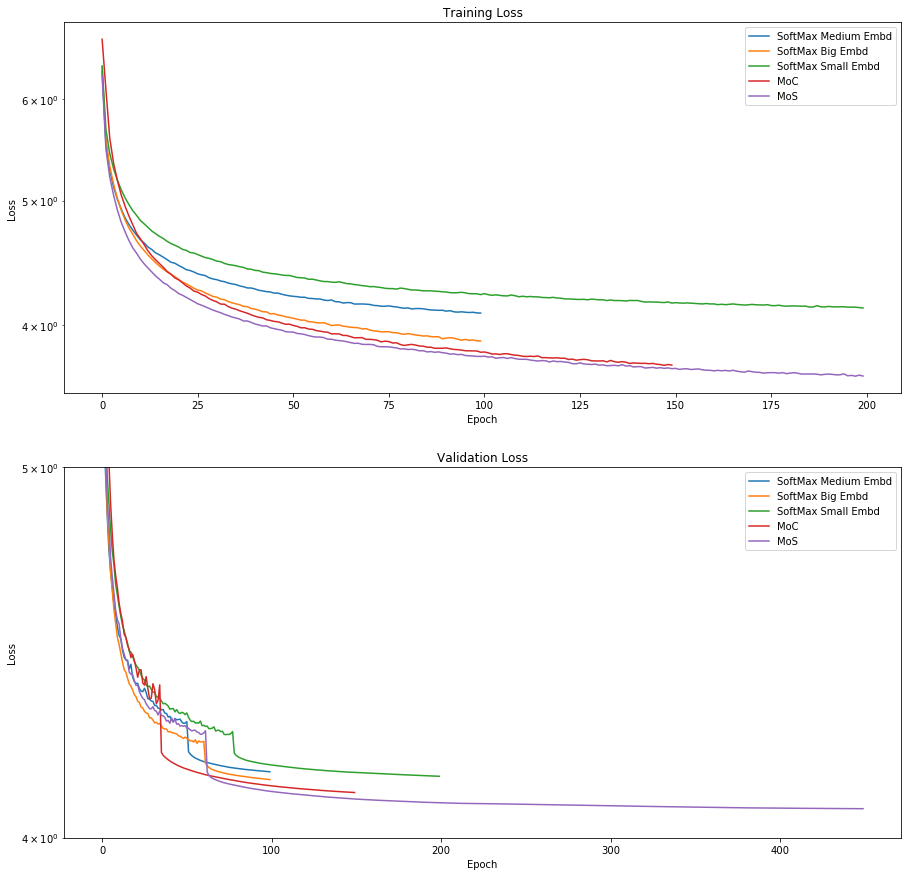

In [44]:
fig = plt.figure(figsize=(15, 15))
train_ax = fig.add_subplot(211)
train_ax.set(xlabel='Epoch', ylabel='Loss',
       title='Training Loss')
train_ax.set_yscale('log')

val_ax = fig.add_subplot(212)
val_ax.set(xlabel='Epoch', ylabel='Loss',
       title='Validation Loss')
val_ax.set_yscale('log')
val_ax.set_ylim(top=5, bottom=4)

hist = unserialize("Experiments/PTB-SoftMax/500EmbLr30", "history")
train_loss = compute_train_epoch_loss(hist, 5)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:,1]
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='SoftMax Medium Embd')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='SoftMax Medium Embd')

hist = unserialize("Experiments/PTB-SoftMax/600EmbLr20", "history")
train_loss = compute_train_epoch_loss(hist, 5)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:,1]
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='SoftMax Big Embd')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='SoftMax Big Embd')

hist = unserialize("Experiments/PTB-SoftMax/400EmbLr20", "history")
train_loss = compute_train_epoch_loss(hist, 5)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:,1]
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='SoftMax Small Embd')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='SoftMax Small Embd')

hist = unserialize("Experiments/PTB-MoC-2", "history")
train_loss = compute_train_epoch_loss(hist, 5)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:,1]
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='MoC')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='MoC')

hist = unserialize("Experiments/PTB-MoS-1", "history")
hist['train_errs'] = hist['train_errs'][:200*5]
train_loss = compute_train_epoch_loss(hist, 5)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:,1]
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='MoS')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='MoS')

train_ax.legend()
val_ax.legend()
plt.show()

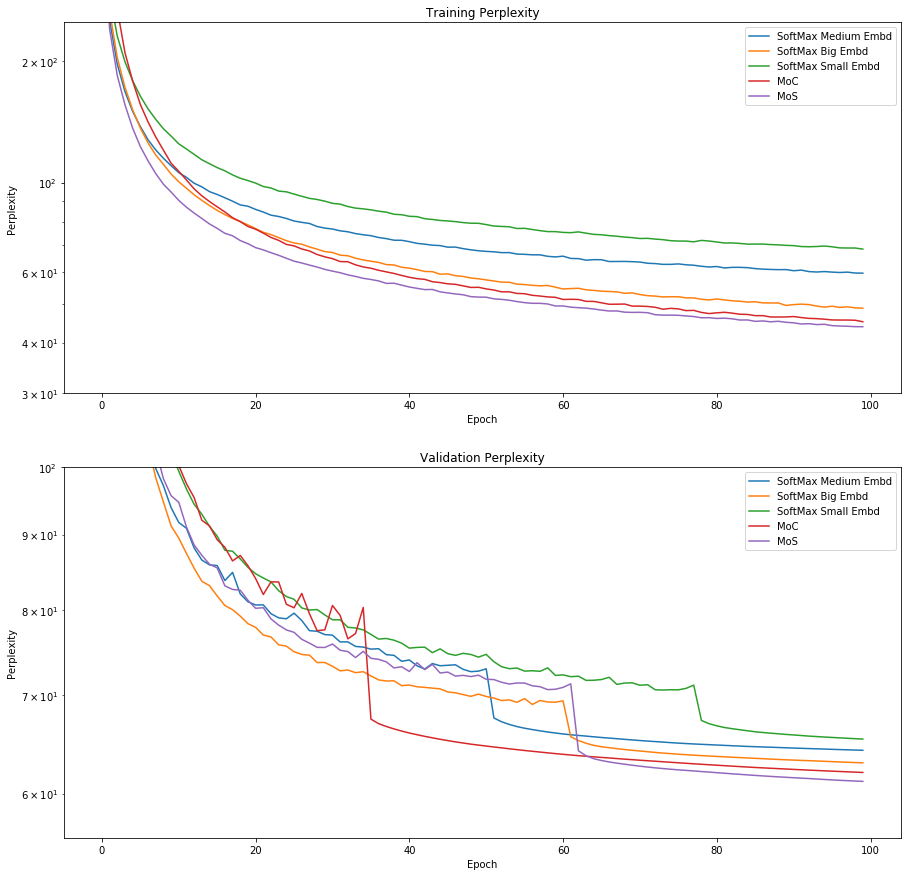

In [8]:
# limited Y axis

fig = plt.figure(figsize=(15, 15))
train_ax = fig.add_subplot(211)
train_ax.set(xlabel='Epoch', ylabel='Perplexity',
       title='Training Perplexity')
train_ax.set_yscale('log')
train_ax.set_ylim(top=250, bottom=30)

val_ax = fig.add_subplot(212)
val_ax.set(xlabel='Epoch', ylabel='Perplexity',
       title='Validation Perplexity')
val_ax.set_yscale('log')
val_ax.set_ylim(top=100, bottom=56)

hist = unserialize("Experiments/PTB-SoftMax/500EmbLr30", "history")
train_loss = compute_train_epoch_loss(hist, 5)[:100]
train_loss = np.exp(train_loss)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:100,1]
val_loss = np.exp(val_loss)
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='SoftMax Medium Embd')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='SoftMax Medium Embd')

hist = unserialize("Experiments/PTB-SoftMax/600EmbLr20", "history")
train_loss = compute_train_epoch_loss(hist, 5)[:100]
train_loss = np.exp(train_loss)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:100,1]
val_loss = np.exp(val_loss)
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='SoftMax Big Embd')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='SoftMax Big Embd')

hist = unserialize("Experiments/PTB-SoftMax/400EmbLr20", "history")
train_loss = compute_train_epoch_loss(hist, 5)[:100]
train_loss = np.exp(train_loss)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:100,1]
val_loss = np.exp(val_loss)
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='SoftMax Small Embd')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='SoftMax Small Embd')

hist = unserialize("Experiments/PTB-MoC-2", "history")
train_loss = compute_train_epoch_loss(hist, 5)[:100]
train_loss = np.exp(train_loss)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:100,1]
val_loss = np.exp(val_loss)
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='MoC')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='MoC')

hist = unserialize("Experiments/PTB-MoS-1", "history")
hist['train_errs'] = hist['train_errs'][:200*5]
train_loss = compute_train_epoch_loss(hist, 5)[:100]
train_loss = np.exp(train_loss)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:100,1]
val_loss = np.exp(val_loss)
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='MoS')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='MoS')

train_ax.legend()
val_ax.legend()
plt.show()

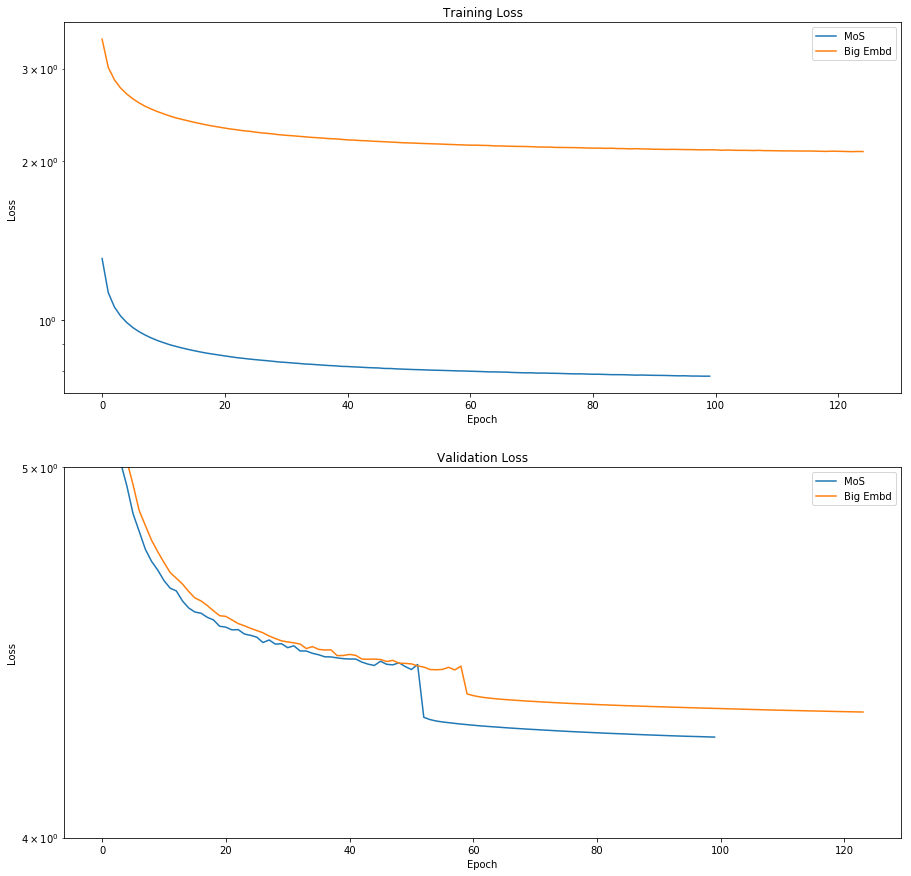

In [45]:
fig = plt.figure(figsize=(15, 15))
train_ax = fig.add_subplot(211)
train_ax.set(xlabel='Epoch', ylabel='Loss',
       title='Training Loss')
train_ax.set_yscale('log')

val_ax = fig.add_subplot(212)
val_ax.set(xlabel='Epoch', ylabel='Loss',
       title='Validation Loss')
val_ax.set_yscale('log')
val_ax.set_ylim(top=5, bottom=4)

hist = unserialize("Experiments/WT2MoS", "history")
train_loss = compute_train_epoch_loss(hist, 10)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:,1]
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='MoS')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='MoS')

hist = unserialize("Experiments/WT2NoMoSCEmb550", "history")
train_loss = compute_train_epoch_loss(hist, 7)
val_loss = np.array(hist["val_errs"] + hist["val_errs2"])[:,1]
train_ax.plot(np.arange(train_loss.shape[0]), train_loss, label='Big Embd')
val_ax.plot(np.arange(val_loss.shape[0]), val_loss, label='Big Embd')


train_ax.legend()
val_ax.legend()
plt.show()

SVD is decomposition of a matrix into three matrices : \begin{equation}A = UWV\end{equation}

where $A$ is $NxM$ matrix, $U$ and $V$ are matrices of sizes $NxN$ and $MxM$. The $W$ is $NxM$ diagonal matrix, whose values are called singular values.

The SVD decomposition has many applications, but authors of the paper use it to estimate a rank of the matrix $A$. Columns of $U$ matrix, whose corresponding singular values are non-zero, are spanning a range for matrix $A$, so the number of non-zero singular values is the rank of matrix $A$.


Authors of the paper use SVD on a  matrix of probabilites for context sequence. Let $B$ be $NxD$ matrix and C be $dxM$ matrix. Authors claim that rank of probabilities matrix $A = BC$ is limited by d. However the matrix of ppbs is a result of matrix multiplication followed by non-linear function ($A = Log(Sotftmax(BC))$) so its rank can be higher than d.

In [8]:
"""
Estimating rank by SVD: https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.linalg.matrix_rank.html 

"""
def probab_matrix(model, input, args):
    model.eval()
    hidden = model.init_hidden(1)
    
    probabs = []
    for i in range(0, input.size(0) - 1, args.bptt):
        X, _ = get_batch(input, i, args, args.bptt, evaluation=True)
        
        log_p, hidden = model.forward(X, hidden, return_linear = False)
        hidden = repackage_hidden(hidden)
        probabs.append(log_p.cpu())
        
    return torch.cat(probabs, dim=0).squeeze()

def get_singular_values(model_folder):
    model = torch.load(os.path.join(model_folder, 'model.pt'))
    A = probab_matrix(model, test_data, args)
    U, S, V = torch.svd(A.data) 
    return S

def get_sv_count(S, m=82430, n=10000):
    A = S.numpy()
    eps = np.finfo(A.dtype).eps / 2.
    return S.size()[0] - (S < S.max() * eps * np.sqrt(m + n + 1.)).sum()

In [ ]:
folder = "Experiments/PTB-SoftMax/500EmbLr30"
S = get_singular_values(folder)
serialize(folder, S, "singular_values_linear")

In [14]:
S = unserialize("Experiments/PTB-SoftMax/500EmbLr30", "singular_values_linear")
print("Linear(500emb) Singular Values count: {}".format(get_sv_count(S)))

S = unserialize("Experiments/PTB-SoftMax/500EmbLr30", "singular_values")
print("SoftMax(500Embedded) Singular Values count: {}".format(get_sv_count(S)))

S = unserialize("Experiments/PTB-SoftMax/600EmbLr30", "singular_values")
print("SoftMax(600Embedded) Singular Values count: {}".format(get_sv_count(S)))

S = unserialize("Experiments/PTB-MoC-2", "singular_values")
print("MoC Singular Values count: {}".format(get_sv_count(S)))

S = unserialize("Experiments/PTB-MoS", "singular_values")
print("MoS Singular Values count: {}".format(get_sv_count(S)))
    
S = unserialize("Experiments/PTB-MoS-1", "singular_values")
print("MoS2 Singular Values count: {}".format(get_sv_count(S)))

S = unserialize("Experiments/PTB-MoS-Experts5", "singular_values")
print("MoS(5 Experts) Singular Values count: {}".format(get_sv_count(S)))

Linear(500emb) Singular Values count: 501
SoftMax(500emb) Singular Values count: 1907
SoftMax(500emb-2) Singular Values count: 1768
SoftMax(600EmbLr30) Singular Values count: 1978
MoC Singular Values count: 4355
MoS Singular Values count: 9979
MoS2 Singular Values count: 9981
MoS(5 Experts) Singular Values count: 9519


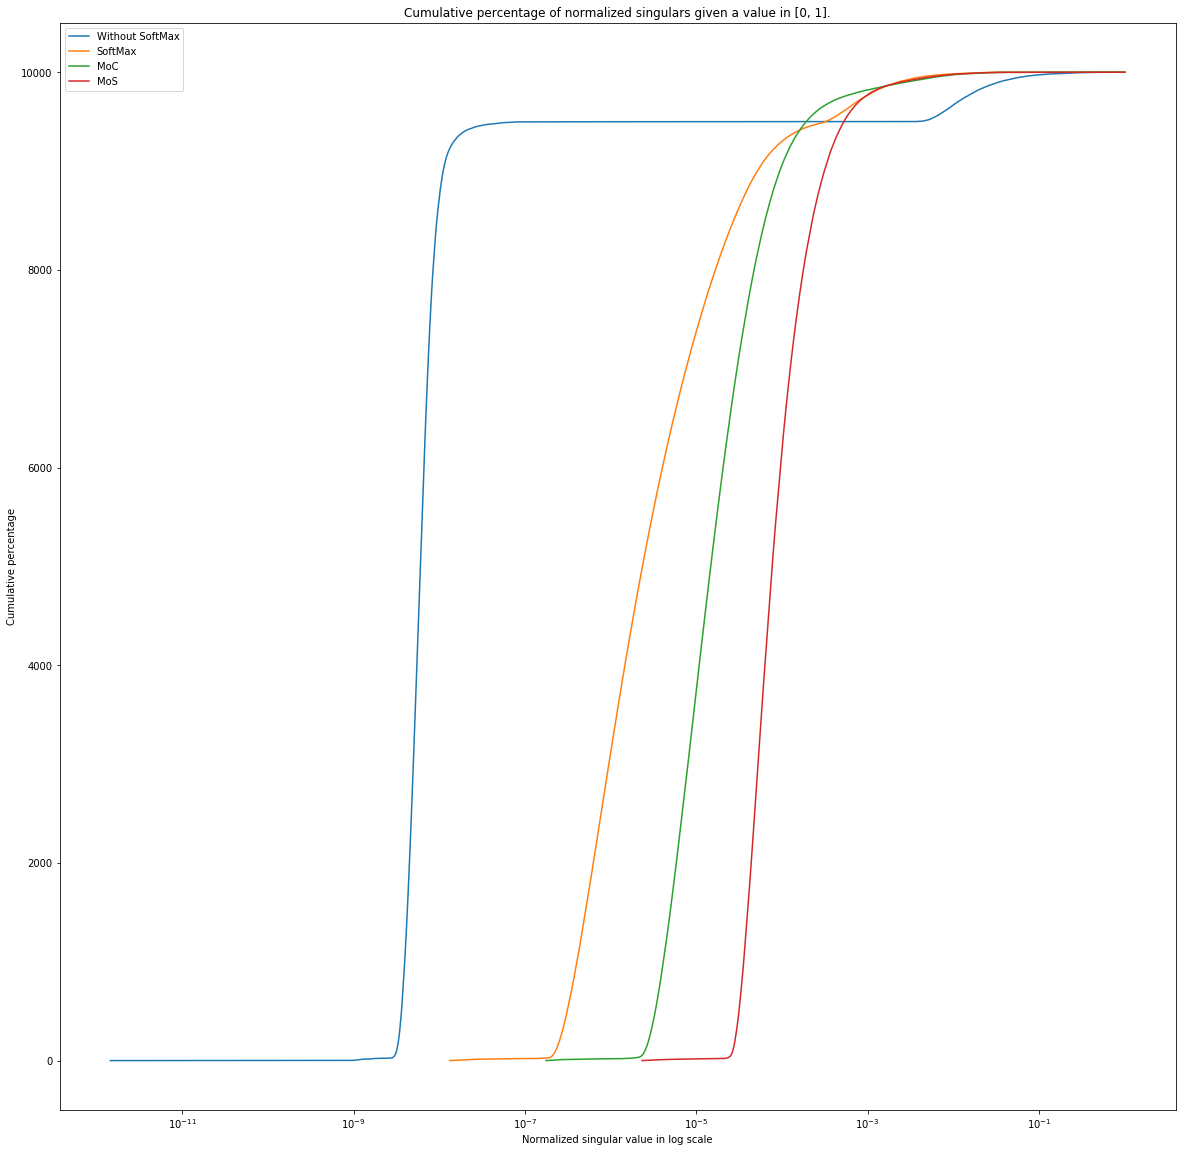

In [11]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.set(xlabel='Normalized singular value in log scale', ylabel='Cumulative percentage',
       title='Cumulative percentage of normalized singulars given a value in [0, 1].')
ax.set_xscale('log')

S = unserialize("Experiments/PTB-SoftMax/500EmbLr30", "singular_values_linear")
S_normalized = S.sort()[0] / S.max()
ax.plot(  S_normalized.numpy(), (np.arange(S.shape[0])).astype('float32'), label='Without SoftMax')

S = unserialize("Experiments/PTB-SoftMax/500EmbLr30", "singular_values")
S_normalized = S.sort()[0] / S.max()
ax.plot(  S_normalized.numpy(), (np.arange(S.shape[0])).astype('float32'), label='SoftMax')

S = unserialize("Experiments/PTB-MoC-2", "singular_values")
S_normalized = S.sort()[0] / S.max()
ax.plot( S_normalized.numpy(), (np.arange(S.shape[0])).astype('float32'), label='MoC')

S = unserialize("Experiments/PTB-MoS", "singular_values")
S_normalized = S.sort()[0] / S.max()
ax.plot( S_normalized.numpy(), (np.arange(S.shape[0])).astype('float32'), label='MoS')


#vals = ax.get_yticks()
# ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

ax.legend()
plt.show()

Kullback–Leibler divergence is a way to compare two probabilty distributions. Authors used it to check how different are probability distributions for some contexts sampled from test data. I fixed sampled contexts $C$ for all experiments. 

First I sampled neighbour pairs of contexts, but KLd was too small compared to paper. So next I sampled contexts randomly.

In [10]:
def KLD(log_ppbs, indexes):
    ppbs = np.exp(log_ppbs.data.numpy())

    half = int(indexes.shape[0]/2)
    X = ppbs[indexes[:half]]
    Y = ppbs[indexes[half:]]

    KLDs = X*(np.log(X) - np.log(Y))
    KLDs = KLDs.sum(1)
    return KLDs.mean()

In [11]:
""" Sampled contexts(fixed pairs) """

indexes = np.random.permutation(test_data.size(0) - (test_data.size(0) % 2))
indexes = indexes[:5000]

model = torch.load(os.path.join('Experiments/PTB-SoftMax/500EmbLr30', 'model.pt'))
log_ppbs = probab_matrix(model, test_data, args)
print("Softmax(500Emb) KLd: {}".format( KLD(log_ppbs, indexes) ))

model = torch.load(os.path.join('Experiments/PTB-SoftMax/600EmbLr30', 'model.pt'))
log_ppbs = probab_matrix(model, test_data, args)
print("Softmax(600Emb) KLd: {}".format( KLD(log_ppbs, indexes) ))

model = torch.load(os.path.join('Experiments/PTB-MoC-2', 'model.pt'))
log_ppbs = probab_matrix(model, test_data, args)
print("MoC KLd: {}".format( KLD(log_ppbs, indexes) ))

model = torch.load(os.path.join('Experiments/PTB-MoS-2', 'model.pt'))
log_ppbs = probab_matrix(model, test_data, args)
print("MoS KLd: {}".format( KLD(log_ppbs, indexes) ))

/pio/os/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/pio/os/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/pio/os/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's 

Softmax(500Emb) KLd: 4.22598123550415
Softmax(600Emb) KLd: 4.325721740722656


/pio/os/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/pio/os/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/pio/os/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/pio/os/anaconda3/lib/python3.6/site-

MoC KLd: 5.062591075897217


/pio/os/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/pio/os/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


MoS KLd: 5.2732014656066895


In [23]:
""" Neighbour contexts """

indexes = np.arange(5000)
indexes[0:2500] = indexes[0:2500] * 2
indexes[2500:] = (indexes[2500:] - 2499) * 2 + 1

model = torch.load(os.path.join('Experiments/PTB-SoftMax/500EmbLr30', 'model.pt'))
log_ppbs = probab_matrix(model, test_data, args)
print("Softmax(500Emb) KLd: {}".format( KLD(log_ppbs, indexes) ))

model = torch.load(os.path.join('Experiments/PTB-SoftMax/600EmbLr30', 'model.pt'))
log_ppbs = probab_matrix(model, test_data, args)
print("Softmax(600Emb) KLd: {}".format( KLD(log_ppbs, indexes) ))

model = torch.load(os.path.join('Experiments/PTB-MoC-2', 'model.pt'))
log_ppbs = probab_matrix(model, test_data, args)
print("MoC KLd: {}".format( KLD(log_ppbs, indexes) ))

model = torch.load(os.path.join('Experiments/PTB-MoS-2', 'model.pt'))
log_ppbs = probab_matrix(model, test_data, args)
print("MoS KLd: {}".format( KLD(log_ppbs, indexes) ))

/pio/os/anaconda3/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'weight_drop.WeightDrop' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/pio/os/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py:224: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  result = self.forward(*input, **kwargs)


Softmax(500Emb) KLd: 3.844630002975464
Softmax(600Emb) KLd: 3.921823501586914
MoC KLd: 4.4841413497924805
MoS KLd: 4.652287006378174
